## Bose-Hubbard model

Consider a lattice with bosons on each site, where operators are defined as the following:
- $\hat{a}_i, \hat{a}_i$ - boson annihilation and creation operators for site $i$,
- $\hat{n}_i$ - boson occupation number operator.

_Bose-Hubbard model includes three terms:_
- chemical potential term $\mu$, which tells the price of adding more particles to the system, 
- hopping amplitude $t$, which defines how likely the bosons are hopping between the nearest neighbour lattice sites
- onsite interaction potential $U$, which prevents bosons from occupying the same lattice site


_Bose-Hubbard hamiltonian:_

$\begin{equation}H = -t\sum_{\left<i, j\right>}\left(\hat{a}_i^\dagger\hat{a}_j + \hat{a}_i\hat{a}_j^\dagger\right) + \frac{U}{2}\sum_{i}\hat{n}_i(\hat{n}_i - 1) - \mu \sum_i \hat{n}_i\end{equation}$


__What can be modelled by Bose-Hubbard model?__

- bosonic atoms on a lattice, superfluid-insulator transition
- certain magnetic insulators



__Plan:__
- Mean-field phase diagram of Bose-Hubbard model
- DMRG phase diagram of Bose-Hubbard model for 1D chain wiht superfluid and Mott insulator phases
- What happens when bond dimension approaches 1 in DMRG simulation? Mean-field solution?
- Measure correlators for each phase, such as superfluid susceptibility, compressibility, correlation radius, density

__Theory:__

The model can be better understood by considering the limiting cases. 

1. $t = 0$ _- no hopping between lattice sites._

In this case the bosons uncouple, so we arrive at sum of one-body hamiltonians

$H = \frac{U}{2}\sum_{i}\hat{n}_i(\hat{n}_i - 1) - \mu \sum_i \hat{n}_i $. 

Clearly, the eigenstates are just states with the same occupation number for each lattice site $\left|\psi_n \right> = \left| n, n, ...,n \right>$, so $E_n = \left< \psi_n \right|H\left| \psi_n \right> = N(\frac{U}{2}n(n - 1) - \mu n)$, where $N$ is the number of lattice sites. To get the groundstate energy, we should find minimum of $E_n$ over occupation number $n$, so the condition is $\partial_n E_n = 0 \Leftrightarrow Un-\frac{U}{2}-\mu = 0$. Taking into account that $n$ is integer, we receive $n = \text{argmin}\left(E_{\left\lfloor{\frac{1}{2} + \frac{\mu}{U}}\right\rfloor},E_{\left\lceil{\frac{1}{2} + \frac{\mu}{U}}\right\rceil}\right) $. What just happened? Now we know that in the limit of no hopping each lattice site contains the same number of bosons, which increases discretely as we tune $\mu/U$. This phase of matter is also called Mott insulator. 

2. $U = 0$ _- no onsite interaction._ 

In this case the hamiltonian takes the form

$H = -t\sum_{\left<i, j\right>}\left(\hat{a}_i^\dagger\hat{a}_j + \hat{a}_i\hat{a}_j^\dagger\right) - \mu \sum_i \hat{n}_i$. Consider 1D chain of atoms

In [86]:
using ITensors, ITensorMPS
using CSV, Tables
using NPZ
using PyPlot
using CurveFit
include("Bose_Hubbard.jl");

In [9]:
μ = 0.0:0.02:1.1
U = 1.0
t = 0.0:0.02:0.4
bonddim_list = [1, 2, 3, 4, 5, 10, 20]
nsweeps_list = [20, 20, 20, 30, 30, 40, 60]
names = [""]

base_filename = "/Users/goloshch/SandBox/DMRG/"

@suppress for k in eachindex(bonddim_list)
    result = zeros((length(μ), length(t)))
    name = "PhaseDiagram:N=50_maxoccupation=5_D=$(bonddim_list[k])_nsweeps=$(nsweeps_list[k]).npz"
    filename = base_filename * name

    @suppress for i in eachindex(μ)
        @suppress for j in eachindex(t)
            H, sites = BoseHubbard(t[j], μ[i], U; max_occupation=5);
            energy, psi = Simulation(H, sites; maxdim=bonddim_list[k], nsweeps=nsweeps_list[k])
            result[i, j] = AverageOccupation(psi);
        end
        npzwrite(filename, Dict("mu" => μ, "t" => t, "U" => U, "navg" => result))
    end
end

InterruptException: InterruptException:

In [17]:
μ = 0.0:0.1:5.0;
U = 1.0
t = 0.05
navg = zeros(length(μ))


@suppress for i in eachindex(μ)
    H, sites = BoseHubbard(t, μ[i], U; max_occupation=8, N=30)
    energy, psi = Simulation(H, sites;maxdim=10,nsweeps=60)
    navg[i] = AverageOccupation(psi)
end;

base_filename = "/Users/goloshch/SandBox/DMRG/data/"
filename = base_filename*"ladder.npz"
npzwrite(filename, Dict("navg" => navg, "mu" => μ, "t" => t, "U" => U))

1. Запустить параллельные вычисления на сервере для фазовой диаграммы с $D=5$ и $nsweeps = 100$. 
2. Посчитать корреляционный радиус. Сначала считается корреляционная функция $\Gamma(r) = \left<a_j^\dagger a_{j+r}\right>$, затем корреляционный радиус из фита

In [23]:
C = zeros((3, 3))
size(C)[1]

3

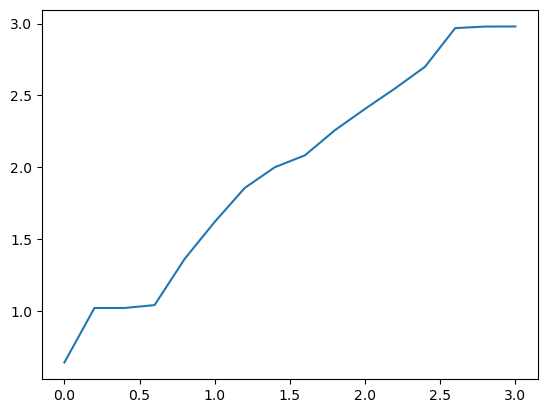

In [56]:
figure()
plot(μ, result)
gcf()

### Корреляционные функции

In [268]:
μ = 0.4
t = 0.4
U = 1.0

L = 50
D = 10
nsweeps = 50
max_occupation = 3

H, sites = BoseHubbard(t, μ, U; N=L, max_occupation=max_occupation)
energy, psi = @suppress Simulation(H, sites; maxdim=D, nsweeps=nsweeps)

C = Correlation(psi)
Cr_f = CorrelationCord(C; avg=false)
ncalc = Occupation(psi);

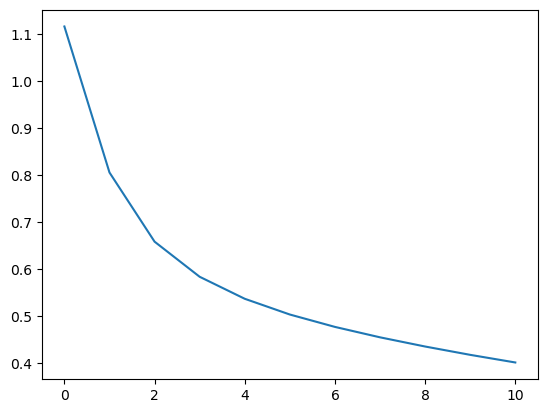

In [269]:
figure()
max_r = 10
plot(Cr_f[center:center+max_r])
gcf()

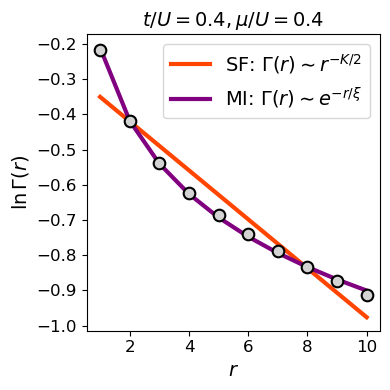

In [271]:
figure()
max_r = 10
center=Int(ceil(L//2))
r = 1:max_r
a, b = linear_fit(r, log.(Cr_f[center+1:center+max_r]))
c, d = linear_fit(log.(r), log.(Cr_f[center+1:center+max_r]))

figure(figsize=(4,4))
plot(r, a .+ b*r, 
    label="SF: "*"\$ \\Gamma(r) \\sim r^{-K/2}\$", 
    linewidth=3,
    color="orangered",
    zorder=-3) 
plot(r, c .+ d*log.(r), 
    label="MI: "*"\$ \\Gamma(r) \\sim e^{-r/\\xi}\$", 
    linewidth=3,
    color="purple") 
scatter(r, log.(Cr_f[center+1:center+max_r]), 
        color="lightgray", 
        zorder=4, 
        s=70,
        edgecolors="black",
        linewidth=1.5)
xlabel("\$ r\$", fontsize=14)
ylabel("\$\\ln \\Gamma(r) \$", fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)

title("\$ t/U=0.4, \\mu/U=0.4 \$", fontsize=14)
legend(fontsize=14)
tight_layout()
savefig("results/correlation_function_MI.pdf", dpi=200)
gcf()

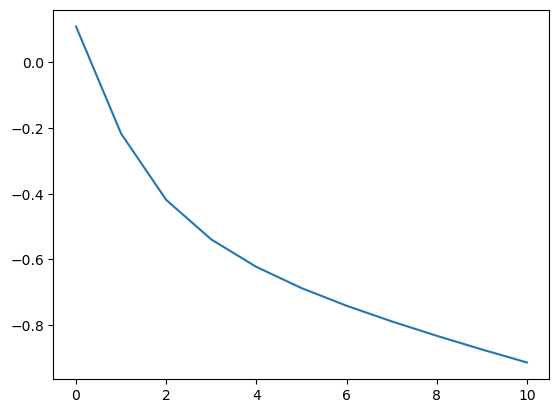

In [160]:
figure()
L = 50
center = Int(ceil(L//2))
plot(r, log.(Cr_f[center:center+max_r]))
gcf()

In [ ]:
Cr_f

In [143]:
linear_fit(r, log.(Cr[1:max_r+1]))
# xi = -1.0/a

(-0.3832389293239945, -0.07743496676979311)

__Импульс CZ, оптимизация - Леонид Герасимов__


- __принцип максимума Понтрягина, теория оптимального управления__
- ставится граничное условие в конечный момент времени $\psi(T)$
- задача Лагранжа - поиск $u(t)$ в виде гладкой функции
- можно получить аналитическое выражение
- теория помогает сильно снизить размерность задачи оптимизации

- при использовании теории не нужно разбивать интервал на кучу временных интервалов, можно получить $u(t)$ в полуаналитическом виде, затем через L-BFGS дооптимизировать форму

- стартуют с лукинского гейта для случая идеального гейта, потом оптимизируют
- для неидеальной блокады стартуют с уже оптимизированного для идеальной блокады


- есть только ошибка неидеальной блокады, дальше хотят учесть некогерентные эффекты: конечное время жизни, рассеяние с промежуточного состояния
- хочется уйти от решения уравнения на матрицу плотности, хотят perturbation theory. Можно ли stochastic wavefunctions использовать? Не знаю. 

- Планируете ли вы учитывать тепловые эффекты, доплера, выключение ловушки?

- Итерационный метод Кротова, GRAPE, CRAB не пробовали

__Возможные задачи:__
- Попробовать MCWF вместо решения Линдблада
- метод Кротова вместо текущего решения с Понтрягиным
- Метод CRAB и GRAPE. 
- Добавить вклад от теплового движения, выключения ловушки, сдвигов отстройки от промежуточного уровня




__Коммментарий:__
- Рябцев придумал какую-то трёхфотонную схему с вырожденным треугольником
- У цезия побольше сверхтонкое расщепление
- Можно не менять направления красного и синего лазеров, а делать однокубитную операцю, которая переводит состояние в себя
- Для оптимизации длительности импульса Кротовым не очень понятно что делать

- Есть метод динамической развязки, окружение описывается как некий резервуар. Затем резервуар подменяется анцильным кубитом, рассматривается взаимодейтсвие основной системы с анцильным кубитом. Далее подбирается импульс, чтобы анцильный кубит (метод DRAG)


__Второй загадочный семинар__

- Что-то с сверхизлучением, Моттовским изолятором
- Моделируется контактным взаимодействием
- Есть цикл работ про controllable collisions от Pole Julien. Светом в течение взаимодействия можно что-то менять. 